# HDBSCAN should work well on embedding representations

In [1]:
import os
import re
import json
import hdbscan

import numpy as np
import pandas as pd

from sklearn.decomposition import PCA
from collections import Counter
import matplotlib.pyplot as plt

import lib.helper as helper
import lib.reporter as reporter
import lib.embedding_models as reps

from gensim.models import Word2Vec

%matplotlib inline

## 1.  Retrieve Corpus

The corpus is being scraped by the "run_news_scrapes.py" script (and windows task scheduler) every 12 hours, a bit past midday and a bit past midnight.

The "bing" corpus are news titles and text extracts gotten from the bing news search API, using a few Home Office - related keywords.

The "RSS" corpus is plugged directly into a number of RSS feeds for world news sites and local british news sites, with no filters for news story types or subjects applied.

In [2]:
# Should be same path for all my PC's, it's where each scrape goes as a separate json file.
storage_path = "D:/Dropbox/news_crow/scrape_results"

# "bing" is targeted news search corpus, "RSS" is from specific world and local news feeds.
corpus_type = "RSS"

# Load up
corpus = helper.load_clean_world_corpus(storage_path, corpus_type)

# Make sure after cleaning etc it's indexed from 0
corpus.reset_index(inplace=True)
corpus.index.name = "node"

# See how it turned out
print(corpus.shape)
corpus.head()

Total files: 495
9.9 percent of files read.
19.8 percent of files read.
29.7 percent of files read.
39.6 percent of files read.
49.5 percent of files read.
59.4 percent of files read.
69.3 percent of files read.
79.2 percent of files read.
89.1 percent of files read.
99.0 percent of files read.
(31393, 9)


,index,title,summary,date,link,source_url,retrieval_timestamp,origin,clean_text
node,,,,,,,,,
0,0,Hurricane Dorian lashes US as Bahamas counts cost,"Life-threatening US storm surges are feared, a...","Thu, 05 Sep 2019 16:03:44 GMT",https://www.bbc.co.uk/news/world-us-canada-495...,http://feeds.bbci.co.uk/news/world/rss.xml,2019-09-05 21:35:06.925873,rss_feed,Hurricane Dorian lashes US as Bahamas counts c...
1,1,Kohistan video murders: Three guilty in 'honou...,They are relatives of a group of Pakistani wom...,"Thu, 05 Sep 2019 13:53:17 GMT",https://www.bbc.co.uk/news/world-asia-49592540,http://feeds.bbci.co.uk/news/world/rss.xml,2019-09-05 21:35:06.925873,rss_feed,Kohistan video murders: Three guilty in 'honou...
2,2,MH17 Ukraine plane crash: 'Key witness' released,A Ukrainian court releases a potentially key w...,"Thu, 05 Sep 2019 13:46:06 GMT",https://www.bbc.co.uk/news/world-europe-49591148,http://feeds.bbci.co.uk/news/world/rss.xml,2019-09-05 21:35:06.925873,rss_feed,MH17 Ukraine plane crash: 'Key witness' releas...
3,3,Article 370: The weddings 'ruined' by Kashmir'...,Indian-administered Kashmir is under a securit...,"Thu, 05 Sep 2019 07:32:34 GMT",https://www.bbc.co.uk/news/world-asia-india-49...,http://feeds.bbci.co.uk/news/world/rss.xml,2019-09-05 21:35:06.925873,rss_feed,Article 7: The weddings 'ruined' by Kashmir's ...
4,4,Syria war: Turkey warns Europe of new migrant ...,President Erdogan demands international help t...,"Thu, 05 Sep 2019 16:11:48 GMT",https://www.bbc.co.uk/news/world-europe-49599297,http://feeds.bbci.co.uk/news/world/rss.xml,2019-09-05 21:35:06.925873,rss_feed,Syria war: Turkey warns Europe of new migrant ...


## 2.  Build Text Model (Representation, eg; word2vec, entities list...)

- Trying with the world corpus and with the bing corpus, neither worked with InferSent.  Suspect the problem lies in the PCA step, which may not be working well on this high-dimensional (vector length = 4096) form.
- Summed keywords works rather better with the world corpus.
- Summed keywords still fail the bing/home office corpus, giving me a cluster about "immigration" and a cluster for the American Supreme Court.

## 2a.  Try a really simple averaged word vector model!

With a complex noun extraction function 'cause that part's slow so I multi-threaded it.

In [3]:
vec_size = 100

# Get phrase-conjoined, stem tokens
corpus['phrase_tokens'] = helper.get_phrased_nouns(corpus['clean_text'])

# Detect and conjoin bigrams
model = Word2Vec(corpus['phrase_tokens'], size=vec_size, window=5, min_count=5, workers=10)

In [4]:
def get_averaged_vec(token_list, model):
    
    vecs = []
    for token in token_list:
        try:
            vector = model.wv[token]
        except: 
            vector = np.zeros(vec_size)
        vecs.append(vector)
    
    if len(vecs) > 0:
        return np.mean(np.asarray(vecs), axis=0)
    else:
        return np.zeros(vec_size)

In [5]:
vectors = [get_averaged_vec(tokens, model) for tokens in corpus['phrase_tokens']]

## 3. Cluster Text

This is the part where the pipelines get a little more experimental
- First; PCA (HDBSCAN prefers < 50 dimensions if possible) (also, try just fitting 50 vectors!)
- Second; HDBSCAN clustering

In [6]:
embeddings_array = np.vstack(vectors)

# First, PCA the data
pca = PCA(n_components=20, svd_solver='full')

# Fit and check
embeddings_pca = pca.fit_transform(embeddings_array)

# Diagnostic stats - both should show exponential decay
print(pca.explained_variance_ratio_)
print(pca.singular_values_) 

[9.37793388e-01 4.44389044e-02 1.30304660e-02 1.73716113e-03
 1.39526511e-03 3.64246534e-04 3.20943652e-04 1.39174686e-04
 1.14356507e-04 1.07297489e-04 5.40238173e-05 4.76866081e-05
 3.35252146e-05 2.61702227e-05 2.44438153e-05 1.91093728e-05
 1.85844037e-05 1.70683883e-05 1.41808093e-05 1.35237491e-05]
[187.85321193  40.89278729  22.14343623   8.08509437   7.24591791
   3.70222454   3.47519707   2.2884697    2.07441423   2.00936957
   1.42579693   1.33956335   1.12318378   0.99235886   0.9590683
   0.84798517   0.83625621   0.80142207   0.73049214   0.71336795]


In [15]:
# Clusterer fitting
clusterer = hdbscan.HDBSCAN(min_cluster_size=5, min_samples=10)
clusterer.fit(embeddings_pca)

# Diagnostic - calculate percentage of records assigned "outlier"
print("Percent outlier: ", 100.0 * sum(clusterer.labels_ == -1) / clusterer.labels_.shape[0])

# number of clusters created
print("Number of clusters: ", len(pd.unique(clusterer.labels_)))

# Record cluster each was assigned to
corpus['cluster'] = clusterer.labels_

# Record the reverse of outlier score (therefore, higher number = higher certainty of membership)
corpus['score'] = 1.0 - clusterer.outlier_scores_

corpus.to_csv("working/RSS_clustered_w2v_pca.csv", index=False)

Percent outlier:  66.06568343261236
Number of clusters:  257


C:\ProgramData\Anaconda3\lib\site-packages\hdbscan\hdbscan_.py:1052: RuntimeWarning: invalid value encountered in double_scalars
  self._outlier_scores = outlier_scores(self._condensed_tree)


In [16]:
# For calculating silhouette score, a gauge of how well separated clusters
# are in some spatial representation
from sklearn.metrics import silhouette_score

# Filter out the outliers
embeddings_score = embeddings_pca[clusterer.labels_ != -1]
labels_score = clusterer.labels_[clusterer.labels_ != -1]

score = silhouette_score(embeddings_score, labels_score, metric="cosine")
score

0.13214517710327123

In [17]:
Counter(clusterer.labels_)

Counter({-1: 20740,
         159: 1690,
         255: 3804,
         183: 18,
         88: 11,
         167: 12,
         114: 25,
         135: 33,
         112: 20,
         158: 35,
         0: 21,
         47: 18,
         25: 30,
         58: 37,
         11: 167,
         61: 87,
         133: 9,
         56: 16,
         90: 15,
         85: 20,
         117: 33,
         6: 70,
         66: 21,
         245: 70,
         104: 5,
         10: 53,
         29: 66,
         87: 10,
         180: 12,
         254: 46,
         156: 5,
         77: 10,
         60: 16,
         28: 19,
         86: 6,
         205: 58,
         2: 13,
         68: 29,
         54: 12,
         231: 12,
         15: 11,
         149: 31,
         176: 31,
         209: 16,
         165: 44,
         30: 32,
         134: 6,
         131: 6,
         138: 34,
         143: 64,
         96: 15,
         239: 86,
         35: 19,
         123: 93,
         175: 8,
         14: 7,
         186: 22,
     

C:\ProgramData\Anaconda3\lib\site-packages\dateutil\parser\_parser.py:1218: UnknownTimezoneWarning: tzname EDT identified but not understood.  Pass `tzinfos` argument in order to correctly return a timezone-aware datetime.  In a future version, this will raise an exception.
  category=UnknownTimezoneWarning)
C:\ProgramData\Anaconda3\lib\site-packages\dateutil\parser\_parser.py:1218: UnknownTimezoneWarning: tzname EST identified but not understood.  Pass `tzinfos` argument in order to correctly return a timezone-aware datetime.  In a future version, this will raise an exception.
  category=UnknownTimezoneWarning)
D:\Martin\Documents\GitHub\news_crow\lib\reporter.py:37: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df['sentences'] = df['tokens'].ap

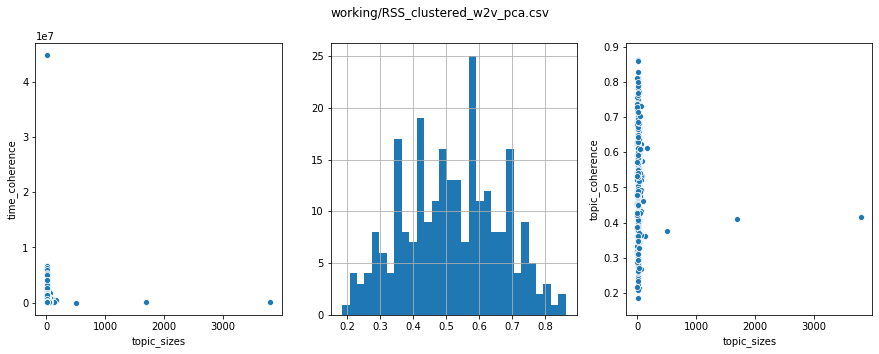

In [18]:
corpus = pd.read_csv("working/RSS_clustered_w2v_pca.csv")
stats, coherences, results = reporter.report_corpus_model_coherence("working/RSS_clustered_w2v_pca.csv")

## 4. Cluster text with Spectral Clustering
Not working on high-dimensional data

## 5. Cluster text with Kmeans

Percent outlier:  0.0
Number of clusters:  200


C:\ProgramData\Anaconda3\lib\site-packages\dateutil\parser\_parser.py:1218: UnknownTimezoneWarning: tzname EDT identified but not understood.  Pass `tzinfos` argument in order to correctly return a timezone-aware datetime.  In a future version, this will raise an exception.
  category=UnknownTimezoneWarning)
C:\ProgramData\Anaconda3\lib\site-packages\dateutil\parser\_parser.py:1218: UnknownTimezoneWarning: tzname EST identified but not understood.  Pass `tzinfos` argument in order to correctly return a timezone-aware datetime.  In a future version, this will raise an exception.
  category=UnknownTimezoneWarning)
D:\Martin\Documents\GitHub\news_crow\lib\reporter.py:37: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df['sentences'] = df['tokens'].ap

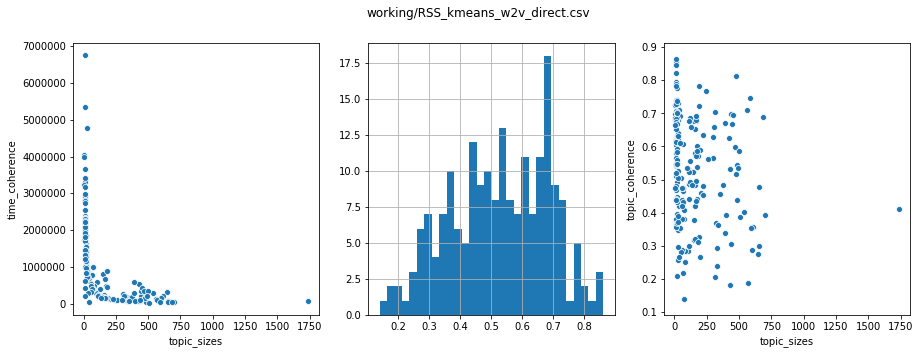

In [13]:
#from nltk.cluster.kmeans import KMeansClusterer
from sklearn.cluster import KMeans

#kmc = KMeansClusterer(num_means=60, distance=cosine_similarity)
#clusters = kmc.cluster(embeddings_array, True, trace=True)
#clusters

kmeans = KMeans(n_clusters=200, random_state=0).fit(embeddings_array)

# Diagnostic - calculate percentage of records assigned "outlier"
print("Percent outlier: ", 100.0 * sum(kmeans.labels_ == -1) / kmeans.labels_.shape[0])

# number of clusters created
print("Number of clusters: ", len(pd.unique(kmeans.labels_)))

# Record cluster each was assigned to
corpus['cluster'] = kmeans.labels_

# Record the reverse of outlier score (therefore, higher number = higher certainty of membership)
corpus['score'] = 1.0

# If cluster is smaller than minimum limit, designate as outlier
cs_lookup = corpus['cluster'].value_counts().to_dict()
corpus['cluster'] = corpus['cluster'].apply(lambda x: -1 if (cs_lookup[x] < 5) else x)

corpus.to_csv("working/RSS_kmeans_w2v_direct.csv", index=False)

stats, coherences, results = reporter.report_corpus_model_coherence("working/RSS_kmeans_w2v_direct.csv")

Percent outlier:  0.0
Number of clusters:  200


C:\ProgramData\Anaconda3\lib\site-packages\dateutil\parser\_parser.py:1218: UnknownTimezoneWarning: tzname EDT identified but not understood.  Pass `tzinfos` argument in order to correctly return a timezone-aware datetime.  In a future version, this will raise an exception.
  category=UnknownTimezoneWarning)
C:\ProgramData\Anaconda3\lib\site-packages\dateutil\parser\_parser.py:1218: UnknownTimezoneWarning: tzname EST identified but not understood.  Pass `tzinfos` argument in order to correctly return a timezone-aware datetime.  In a future version, this will raise an exception.
  category=UnknownTimezoneWarning)
D:\Martin\Documents\GitHub\news_crow\lib\reporter.py:37: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df['sentences'] = df['tokens'].ap

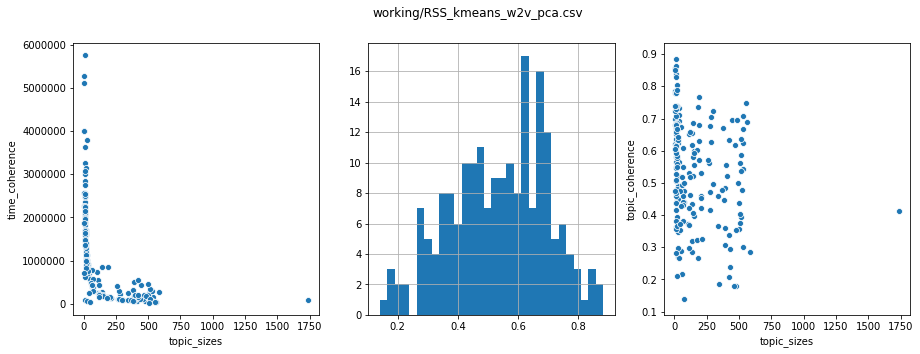

In [14]:
#from nltk.cluster.kmeans import KMeansClusterer
from sklearn.cluster import KMeans

#kmc = KMeansClusterer(num_means=60, distance=cosine_similarity)
#clusters = kmc.cluster(embeddings_array, True, trace=True)
#clusters

kmeans = KMeans(n_clusters=200, random_state=0).fit(embeddings_pca)

# Diagnostic - calculate percentage of records assigned "outlier"
print("Percent outlier: ", 100.0 * sum(kmeans.labels_ == -1) / kmeans.labels_.shape[0])

# number of clusters created
print("Number of clusters: ", len(pd.unique(kmeans.labels_)))

# Record cluster each was assigned to
corpus['cluster'] = kmeans.labels_

# Record the reverse of outlier score (therefore, higher number = higher certainty of membership)
corpus['score'] = 1.0

# If cluster is smaller than minimum limit, designate as outlier
cs_lookup = corpus['cluster'].value_counts().to_dict()
corpus['cluster'] = corpus['cluster'].apply(lambda x: -1 if (cs_lookup[x] < 5) else x)

corpus.to_csv("working/RSS_kmeans_w2v_pca.csv", index=False)

stats, coherences, results = reporter.report_corpus_model_coherence("working/RSS_kmeans_w2v_pca.csv")